<a href="https://colab.research.google.com/github/albercej/zrh/blob/main/ai/stock-prediction-ai-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install loguru
!pip install yahoo_fin
#!pip install yfinance

     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 46.4 MB/s 
     |████████████████████████████████| 112 kB 50.4 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=edf522869961ca0032b27d43fe47d8d135fde621652626720e4fa73a047fbce1
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=73e69599d8f25c535e3b398a146e131ba54cab9312042b704bb1a308f9ac9ad2
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=c574afcfafad102a6ddc7a20d402d48558532e79b676b272607b842ab17f5f7c
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

In [5]:
import datetime
from loguru import logger
import os
import sys
import pandas as pd
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())
from yahoo_fin import stock_info as si

In [6]:
def get_biz_days_delta_date(start_date_str, delta_days):
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = start_date + (delta_days * US_BUSINESS_DAY)
    end_date_str = datetime.datetime.strftime(end_date, "%Y-%m-%d")
    return end_date_str

In [7]:
def load_price_data(symbol, start_date_str, end_date_str):
    # Download data
    try:
        df = si.get_data(symbol, start_date=start_date_str, end_date=end_date_str, index_as_date=False)
        return df
    except:
        print('Error loading stock data for ' + symbol)
        return None

In [8]:
def cleanup_daily_file(df):
    #  Select columns
    df.dropna(inplace=True)
    df.drop("close", axis=1, inplace=True)
    df.drop("volume", axis=1, inplace=True)
    df.drop("ticker", axis=1, inplace=True)
    df.reset_index(inplace=True)
    #  Rearrange column order
    df.drop("index", axis=1, inplace=True)
    df = df[['adjclose', 'date']]  # , 'open','high','low',

    return df

In [9]:
def get_train_test_range(df, start_date_str, target_date_str):
    query = f"(date >= '{start_date_str}') and (date <= '{target_date_str}')"
    train_test_df = df.query(query).copy()
    return train_test_df

In [10]:
def get_display_range(df, start_date_str, target_date_str, forecast_steps):
    #  Get full date range
    full_range_date_str = get_biz_days_delta_date(target_date_str, forecast_steps )
    query = f"(date >= '{start_date_str}') and (date <= '{full_range_date_str}')"
    full_date_range_df = df.query(query).copy()
    return full_date_range_df

In [11]:
def train_test_split(df, start_date_str, test_date_str, target_date_str):
    train_query = f"(date >= '{start_date_str}') and (date < '{test_date_str}')"
    train_df = df.query(train_query).copy()
    train_df = train_df.set_index('date')

    test_query = f"(date >= '{test_date_str}') and (date <= '{target_date_str}')"
    test_df = df.query(test_query).copy()
    test_df = test_df.set_index('date')

    return train_df, test_df

In [12]:
def scale_data(train_df, test_df, time_steps):
    full_scalar = MinMaxScaler(feature_range=(0, 1))
    full_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
    full_df_scaled = full_scalar.fit_transform(full_df)

    train_scaler = MinMaxScaler(feature_range=(0, 1))
    train_df_scaled = train_scaler.fit_transform(train_df)

    test_scaler = MinMaxScaler(feature_range=(0, 1))
    test_df_range = full_df[len(full_df) - len(test_df) - time_steps:]
    test_df_scaled = test_scaler.fit_transform(test_df_range)

    return full_scalar, train_df_scaled, test_df_scaled, full_df_scaled

In [13]:
def create_X_ys(df_scaled, time_steps, forecast_steps):
    X = []
    y = []
    for i in range(time_steps, df_scaled.shape[0] - forecast_steps + 1):
        X.append(df_scaled[i - time_steps:i])
        y.append(df_scaled[i:i + forecast_steps])

    X = np.array(X)
    y = np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))
    y = np.reshape(y, (y.shape[0], y.shape[1] * y.shape[2]))

    return X, y

In [14]:
def create_X(df_scaled, time_steps):
    X = []

    for i in range(time_steps, df_scaled.shape[0] + 1):
        X.append(df_scaled[i - time_steps:i])

    X = np.array(X)

    X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))

    return X

In [15]:
def build_model( time_steps, n_forecast_steps, n_features):
    model = Sequential()

    # 1st layer with Dropout regularisation
    # * units = add x neurons is the dimensionality of the output space
    # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
    # * input_shape => Shape of the training dataset
    input_shape = (time_steps, n_features)
    model.add(LSTM(units=800, return_sequences=True, input_shape=input_shape))
    # x% of the layers will be dropped
    model.add(Dropout(0.5))
    # 2nd LSTM layer
    # * units = add x neurons is the dimensionality of the output space
    # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
    model.add(LSTM(units=400, return_sequences=True))
    # x% of the layers will be dropped
    model.add(Dropout(0.5))
    # 3rd LSTM layer
    # * units = add x neurons is the dimensionality of the output space
    # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
    model.add(LSTM(units=400, return_sequences=True))
    # x% of the layers will be dropped
    model.add(Dropout(0.5))
    # 4th LSTM layer
    # * units = add x neurons is the dimensionality of the output space
    model.add(LSTM(units=400))
    # 50% of the layers will be dropped
    model.add(Dropout(0.5))

    # Dense layer that specifies an output of one unit
    model.add(Dense(units=n_forecast_steps))

    return model

In [16]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])
    return history

In [17]:
def create_predictions(model, X_full):
    full_pred_y = model.predict(X_full)
    return full_pred_y

In [18]:
def inverse_scale(full_scalar, full_pred_y):
    full_pred_y_norm = full_scalar.inverse_transform(full_pred_y)
    full_pred_y_norm = pd.DataFrame(full_pred_y_norm)

    return full_pred_y_norm

In [19]:
def create_future_predictions(pred_y_norm, time_steps):
    future_predict = pred_y_norm.iloc[-1, 0:time_steps]

    future_df = pd.DataFrame(future_predict.values, columns=['adjclose'])

    return future_df

In [20]:
def plot_predictions(symbol, target_date_str, actual_df, pred_y_norm, future_df):
    plt.figure(figsize=(16, 6))
    plt.plot(actual_df['adjclose'], color='blue', label='Actual', linewidth=0.8)

    plt.plot(pred_y_norm[0], color='green', label='Predicted', linewidth=0.8)

    plt.plot(future_df['adjclose'], color='red', label='Future', linewidth=0.8)

    plt.axvline(x=len(pred_y_norm), color='r', linewidth=0.4)
    plt.axvline(x=len(actual_df) - 20, color='r', linewidth=0.4)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Prediction')

    #  Show plot
    plt.show()

In [21]:
def run(cfg):
    symbol = cfg["symbol"]
    total_days = cfg["total_days"]
    target_date_str = cfg["target_date_str"]
    split_ratio = cfg["split_ratio"]
    time_steps = cfg["time_steps"]
    forecast_steps = cfg["forecast_steps"]
    target_date_str = cfg["target_date_str"]
    batch_size = cfg["batch_size"]
    epochs = cfg["epochs"]
    patience = cfg["patience"]
    n_features = 1
    
    today = datetime.date.today()
    today_str = today.strftime("%Y-%m-%d")


    df = load_price_data(symbol, None, today_str)
    df = cleanup_daily_file(df)

    #  calculate start date
    start_date_str = get_biz_days_delta_date(target_date_str, -total_days)
  
    train_test_df = get_train_test_range(df, start_date_str, target_date_str)
    display_df = get_display_range(df, start_date_str, target_date_str, forecast_steps)
   
    #  Calculate test days
    test_days = int(total_days * split_ratio)
    test_date_str = get_biz_days_delta_date(target_date_str, -test_days)

    train_df, test_df = train_test_split(train_test_df, start_date_str, test_date_str, target_date_str)

    full_scalar, train_df_scaled, test_df_scaled, full_df_scaled = scale_data(train_df, test_df, time_steps)

    #  Create X's and y's
    X_train, y_train = create_X_ys(train_df_scaled, time_steps, forecast_steps)
    X_test, y_test = create_X_ys(test_df_scaled, time_steps, forecast_steps)
    X_full = create_X(full_df_scaled, time_steps)

    print('Building model')
    model = build_model(time_steps, forecast_steps, n_features)
    print(model.summary())
    

    train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, patience)

    #  Create predictions
    full_pred_y = create_predictions(model, X_full)
    full_pred_y_norm = inverse_scale(full_scalar, full_pred_y)

    #  Concat train and test predictions
    full_pred_y_norm.index += time_steps - 1

    train_test_df_display = train_test_df.copy()
    train_test_df_display.drop('date', axis=1, inplace=True)
    train_test_df_display.reset_index(drop=True, inplace=True)

    future_df = create_future_predictions(full_pred_y_norm, time_steps)
    future_df.index += len(train_test_df_display) - 2

    full_display_df = display_df.copy()
    full_display_df.drop('date', axis=1, inplace=True)
    full_display_df.reset_index(drop=True, inplace=True)
    
    plot_predictions(symbol, target_date_str, full_display_df, full_pred_y_norm, future_df)

In [22]:
#  Base configuration
cfg = {"symbol": "TSLA",
       "target_date_str": '2021-12-01',
       "total_days": 600,
       "split_ratio": 0.2,
       "epochs": 300,
       "batch_size": 32,
       "time_steps": 30,
       "forecast_steps": 10,
       "patience": 50}

Processing AAPL
Building model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 800)           2566400   
                                                                 
 dropout (Dropout)           (None, 30, 800)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 400)           1921600   
                                                                 
 dropout_1 (Dropout)         (None, 30, 400)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 400)           1281600   
                                                                 
 dropout_2 (Dropout)         (None, 30, 400)           0         
                                                                 
 lstm_3 (LSTM)           

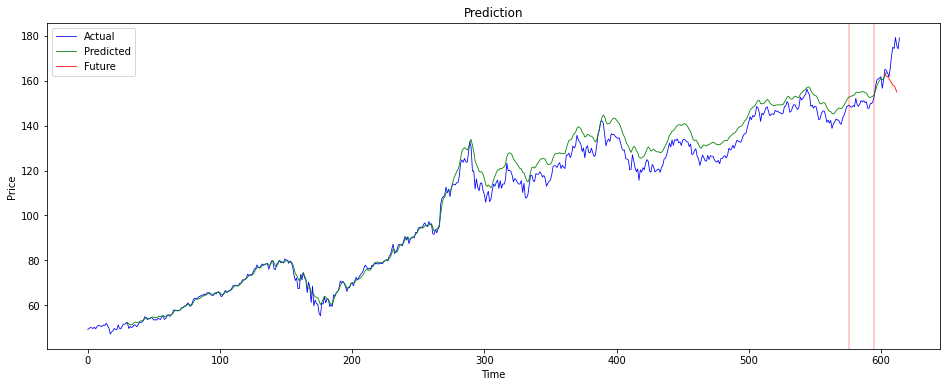

In [23]:
#  Load NASDAQ 100 symbols
nasdaq_100_df = pd.read_csv('https://raw.githubusercontent.com/justmobiledev/python-algorithmic-trading/main/data/nasdaq_100.csv')
symbols = nasdaq_100_df['Symbol'].to_numpy()

#  Run eval for all symbols
for symbol in symbols:
    global cf
    print(f"Processing {symbol}")
    cfg['symbol'] = symbol
    run(cfg)
    break
       